# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### Задание 1.1 (0.5 балла)
Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [31]:
classes = np.array([8, 2])
probabilities = classes / np.sum(classes)
result = np.dot(probabilities, np.log(probabilities)) * -1
print(f'Энтропия для классов: {classes} равна = {result:.2f}')

Энтропия для классов: [8 2] равна = 0.50


Формула энтроии
$$
entropy = -\sum^l_{i=1}p_i*ln(p_i)
$$

Заметим что это можно представить, как скалярное произведение от массива вероятностей на массив логарифмов и умножить полученное значение на -1.

---

#### Задание 1.2 (0.5 балла)
Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [33]:
from collections import Counter

def giniIndex(classes):
    '''
    Функция расчета индекса Джини
    Принимает вектор классов
    (просто формула переписана в код, считая сумму произведений,
    как скалярное произведение)
    '''
    # Для начала посчитаем, как часто встречаются разные классы
    classNumbers = list(Counter(classes).values())
    probabilities = classNumbers / np.sum(classNumbers)
    return np.dot(probabilities, 1 - probabilities)

def impurityFunction(classes):
    '''
    Функция расчета критерия информативности
    Принимает вектор классов
    Просто считает по формуле
    Так как нам не заданы второй и третий параметры функции (j, t)
    мы их просто не используем
    '''
    # Считаем количественное соотношение классов
    currentValue = giniIndex(classes)

    # По условию - влево идут все объекты первого (нулевого класса), а вправо -
    # все второго класса (1)
    left = classes[classes == 0]
    right = classes[classes == 1]

    # Считаем значения, нужные для формулы
    leftValue = len(left) / len(classes) * giniIndex(left)
    rightValue = len(right) / len(classes) * giniIndex(right)

    return currentValue - leftValue - rightValue


# Зададим классы прям как они есть - 8 объектов одного класса и 2 другого
classes = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1])
print(f'Критерий информативности: {impurityFunction(classes):.2f}')

Критерий информативности: 0.32


Как мы видим, критерий информативности довольно большой: поэтому такое разделение хорошее (по логике тоже, если мы четко разделяем 2 класса - это хорошо)

---

#### Задание 1.3 (0.5 балла)
Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
# Так как задача регрессии, а у нас в листе 10 объектов, то
# вероятней всего при попадании объектов в этот лист будет предсказание
# равное среднему значению этих объектов
leaf = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print(f'Предсказание для объектов = {np.mean(leaf)}')

Предсказание для объектов = 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

#### Задание 2.1 (1.5 балла)
Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.


$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

In [6]:
def countVariance(classes):
    '''
    Мера Хаотичности для задачи регрессии (дисперсия)
    '''
    classNumbers = list(Counter(classes).values())
    return np.var(classNumbers)

In [7]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    def impurityFunction(classes, feature, threshold):
        '''
        Функция, которая считает информационный критерий
        (просто почти переписанная формула)

        :param classes: значения таргетов для объектов
        :param feature: значения самого признака
        :param threshold: порог, по которому разбиваем
        '''
        if feature_type == 'categorical':
            # Если признак категориальный, то в левую вершину попадают все,
            # равные нашему порогу, в правую - остальные (по условию)
            left = classes[feature == threshold]
            right = classes[feature != threshold]
        else:
            # Если признак вещественный, то в левую вершину попадают все,
            # меньше нашего порога, в правую - остальные
            left = classes[feature < threshold]
            right = classes[feature >= threshold]
        if task == 'classification':
            # Если классификация - то в качестве меры хаотичности - индекс Джини
            # Из задания 1.2
            currentFunction = giniIndex
        else:
            # Если регрессия - то дисперсия
            currentFunction = countVariance
        return currentFunction(classes) - len(left) / len(classes) * currentFunction(left) - len(right) / len(classes) * currentFunction(right)

    def countImpurityByThreshold(threshold):
        '''
        Функция для векторизации подсчета impurity по порогу
        '''
        nonlocal criteriaValues, bestCriteria, bestThreshold
        # Сохраняем получившееся значение impurity
        criteriaValues.append(impurityFunction(target_vector, feature_vector, threshold))
        # Если оно лучше чем прошлое лучшее, то обновляем лучшее
        if bestCriteria is None or criteriaValues[-1] > bestCriteria:
            bestCriteria = criteriaValues[-1]
            bestThreshold = threshold


    criteriaValues = []
    thresholds = np.array([])
    bestCriteria:int = None
    bestThreshold:int = None
    # В зависимости от типа признаков - по разному берем пороги
    if feature_type == 'categorical':
        # Если категориальные, то вытаскиваем список слов
        thresholds = np.array(list(set(feature_vector)))
    else:
        # Если вещественные, то берем средние значения между соседними
        # элементами (по указаниям так)
        thresholds = np.array(sorted(set(feature_vector)))
        thresholds = list((thresholds[1:] + thresholds[:-1]) / 2)
    # При таком выборе порогов, у нас при любом пороге, объекты попадут и
    # в правую часть, и в левую при разделении (кроме константного признака,
    # но его обрабатывать не нужно по условию)

    # реализация без циклов
    np.vectorize(countImpurityByThreshold, otypes=[None])(thresholds)

    return (thresholds, criteriaValues, bestThreshold, bestCriteria)

Эту функцию можно протестировать на датасете `California`.

In [8]:
from sklearn.datasets import fetch_california_housing

In [9]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
# Посчитаем, что у нас получается для признака MedInc
(x_values, y_values, best_x, best_y) = find_best_split(X['MedInc'], y, 'regression')

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

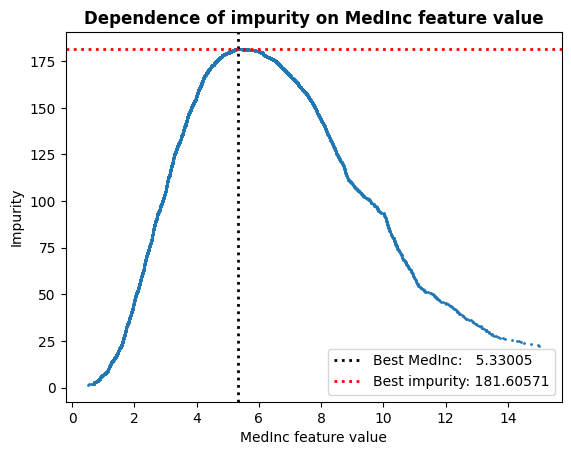

In [11]:
import matplotlib.pyplot as plt

# Построим график

plt.scatter(x_values, y_values, s=1)
plt.axvline(best_x, color='black', linewidth=2, linestyle=':', label=f'Best MedInc:   {best_x:.5f}')
plt.axhline(best_y, color='black', linewidth=2, c='red', linestyle=':', label=f'Best impurity: {best_y:.5f}')
plt.legend()
plt.xlabel('MedInc feature value')
plt.ylabel('Impurity')
plt.title('Dependence of impurity on MedInc feature value', fontweight='bold')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

Как мы видим, лучше всего делит порог ```MedInc = 5.33005```. Соответственно, для первой вершины нам нужно взять предикат

```
data['MedInc'] < 5.33005 => impurity = 181.606
```

При таком предикате, мы получим наилучшее разбиение с самым большим значением impurity.

ЦИКЛЫ НЕ ИСПОЛЬЗОВАЛИСЬ

---

#### Задание 2.2 (1 балл)
Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [12]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            # если разделить не получилось, то переходим к следующему признаку
            if gini is None:
                continue

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (feature_vector < threshold_best)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (feature_vector == threshold_best)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        if self._feature_types[node["feature_split"]] == "real":
            if x[node["feature_split"]] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            return self._predict_node(x, node["right_child"])
        else:
            if x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            return self._predict_node(x, node["right_child"])


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

#### Задание 2.3 (1 балл)
Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [13]:
!wget https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw07-trees/students.csv

students = pd.read_csv('students.csv', sep=',')
students.head()

--2024-05-26 17:37:57--  https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw07-trees/students.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv [following]
--2024-05-26 17:37:57--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7794 (7.6K) [text/plain]
Saving to: ‘students.csv’

students.csv        100%[===================>]   7.61K  --.-KB/s    in 0s      

2024-05-26 17:37:58 (68.8 MB/s) - ‘students.csv’ saved [

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0


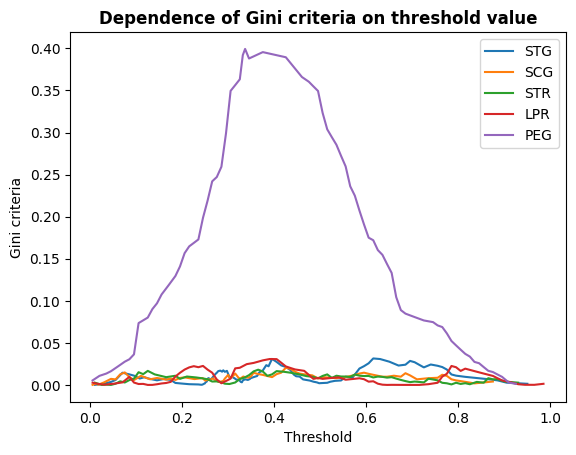

In [14]:
# Строим графики для порогов и критериев джини
columnNames = ['STG', 'SCG', 'STR', 'LPR', 'PEG']

for columnName in columnNames:
    thresholds, ginis, _, _ = find_best_split(students[columnName], students['UNS'])
    plt.plot(thresholds, ginis, label=columnName)

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Gini criteria')
plt.title('Dependence of Gini criteria on threshold value', fontweight='bold')
plt.show()

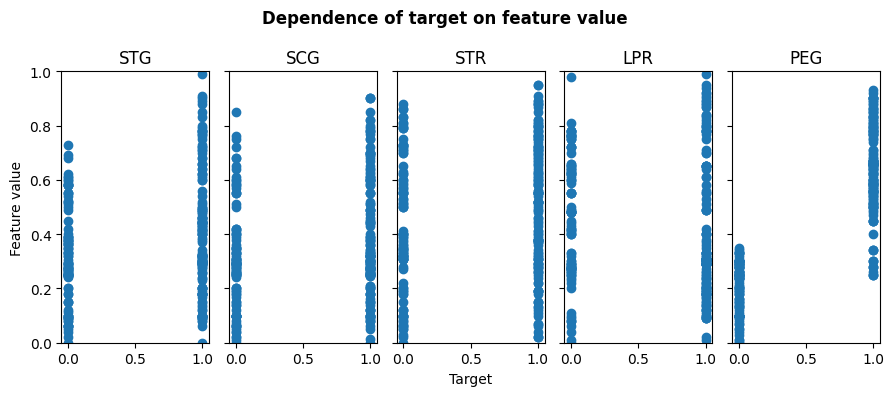

In [15]:
# Строим диаграммы рассеяния
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(9, 4))
fig.suptitle('Dependence of target on feature value', fontweight='bold')
columnNames = ['STG', 'SCG', 'STR', 'LPR', 'PEG']
for index, columnName in enumerate(columnNames):
    axs[index].scatter(students['UNS'], students[columnName])
    axs[index].set_ylim(0, 1)
    axs[index].set_title(columnName)

axs[0].set_ylabel('Feature value')
axs[2].set_xlabel('Target')
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Глядя на кривые для критерия Джини, явно видно, что больше всего для деления подходит признак PEG. То есть по кривой мы видим, что можно выбрать такое значение для порога, что критерий будет большим (то есть выборка разделилась хорошо).

То же самое подтверждает и диаграмма рассеяния. PEG - единственный признак, где можно наглядно увидеть, что класс 0 - приблизительно объекты с признаком PEG меньше какого-то порога, а класс 1 - примерно объекты с признаком PEG больше этого порога.

Чтобы можно было назвать признаки хорошими для почти идеального разделения, их кривая должна иметь явные большие максимумы - горки (которых должно быть мало, желательно 1). Тогда мы понимаем, что если выбрать такой порог, то мы хорошо разделим выборку.

Если же кривая везде примерно на одном уровне, или имеет много максимумов - горок, то по этому признаку будет тяжело разделить нашу выборку. В таких случаях критерий окажется недостаточно большим, чтобы хорошо делить выборку.

---

#### Задание 2.4 (1 балл)
Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [16]:
# Скачиваем таблицу
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)

X = mushroom.data.features
y = mushroom.data.targets

print(y)
X.head()

     poisonous
0            p
1            e
2            e
3            p
4            e
...        ...
8119         e
8120         e
8121         e
8122         p
8123         e

[8124 rows x 1 columns]


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [17]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

columns = list(X.columns)

# Кодируем признаки
for column in columns:
    X[column] = labelEncoder.fit_transform(X[column])

# И таргет
y = np.array(labelEncoder.fit_transform(y))

print(y)
X.head()

[1 0 0 ... 0 1 0]


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1


In [18]:
# Разделим выборку на обучающую и тестовую
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=12, stratify=y)
X_train.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
6072,2,2,4,0,7,1,0,1,0,1,...,2,6,7,0,2,1,0,7,4,2
7557,3,3,2,0,2,1,0,1,0,1,...,1,6,6,0,2,1,0,7,4,0
6833,2,2,2,0,2,1,0,1,0,1,...,1,6,7,0,2,1,0,7,4,2
4129,2,0,2,1,5,1,0,0,7,1,...,2,3,3,0,2,1,4,2,5,0
4916,5,3,9,0,2,1,0,0,3,0,...,1,4,4,0,2,1,2,1,5,0


In [19]:
from sklearn.metrics import accuracy_score

# Создаем дерево
tree = DecisionTree(['categorical'] * X.shape[1])
# Обучаем
tree.fit(X_train.to_numpy(), y_train)
# Делаем предикты
y_train_pred = tree.predict(X_train.to_numpy())
y_test_pred = tree.predict(X_test.to_numpy())

# Считаем accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on train: {accuracy_train:.3f}')
print(f'Accuracy on test:  {accuracy_test:.3f}')

Accuracy on train: 1.000
Accuracy on test:  1.000


Как мы видим, у нас получилось отличное дерево, и на train и на test у нас очень высокая accuracy.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [20]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

!wget https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw07-trees/diabetes.csv

--2024-05-26 17:38:09--  https://github.com/hse-ds/iad-intro-ds/raw/master/2024/homeworks/hw07-trees/diabetes.csv
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv [following]
--2024-05-26 17:38:10--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23105 (23K) [text/plain]
Saving to: ‘diabetes.csv’

diabetes.csv        100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2024-05-26 17:38:10 (20.4 MB/s) - ‘diabetes.csv’ saved [

In [21]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

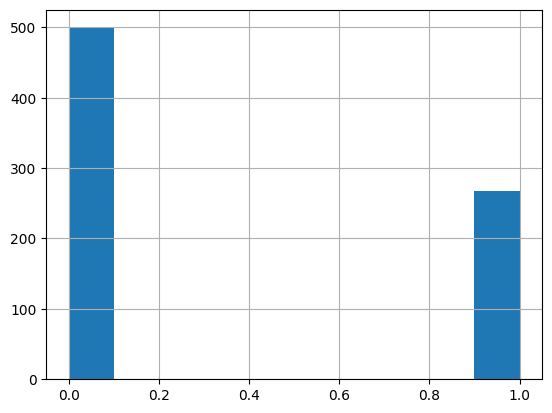

In [22]:
data['Outcome'].hist()
plt.show()

#### Задание 3.1 (0.5 балла)

Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [23]:
# Отделяем таргет
y = data['Outcome']
X = data.drop('Outcome', axis=1)

# Делим на train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=12, stratify=y)
# Делим на train, valid
X_train_train, X_train_valid, y_train_train, y_train_valid = train_test_split(X_train, y_train, train_size=0.7, random_state=12, stratify=y_train)

#### Задание 3.2 (1 балл)
На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

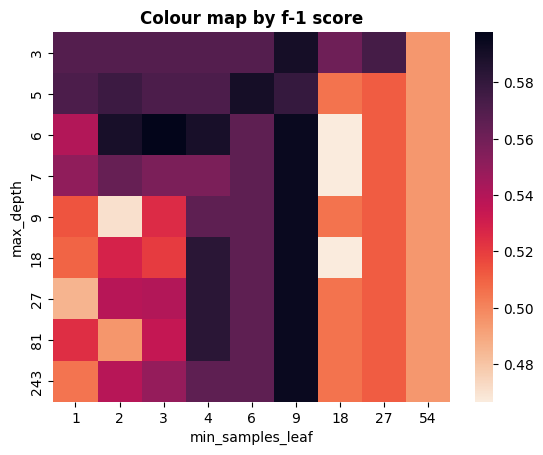

-------------------------
Best max depth: 6
Best min samlpes leaf: 3
Best f1-score: 0.598


In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import seaborn as sns

max_depths = [3, 5, 6, 7, 9, 18, 27, 81, 243]
min_samples_leafs = [1, 2, 3, 4, 6, 9, 18, 27, 54]
values = []

# Сразу будем запоминать лучшее значение
best_max_depth:int = None
best_min_samples_leaf:int = None
best_score:float = None

# Идем по всем глубинам
for max_depth in max_depths:
    cur_values = []
    # И по всем min_samples_leaf
    for min_samples_leaf in min_samples_leafs:
        # Создаем и обучаем дерево
        dtree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        dtree.fit(X_train_train, y_train_train)
        # Делаем предикт
        y_pred = dtree.predict(X_train_valid)
        # Считаем f1_score
        score = f1_score(y_train_valid, y_pred)
        cur_values.append(score)
        if best_score is None or best_score < score:
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf
            best_score = score
    values.append(cur_values)

# Построим heatmap, чтобы было лучше видно, где значения хорошие
data = pd.DataFrame(values, index=max_depths, columns=min_samples_leafs)
sns.heatmap(data, cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.title('Colour map by f-1 score', fontweight='bold')
plt.show()

print('-------------------------')
print(f'Best max depth: {best_max_depth}')
print(f'Best min samlpes leaf: {best_min_samples_leaf}')
print(f'Best f1-score: {best_score:.3f}')

Как мы видим, лучшими оказались max_depth = 6 и min_samples_leaf = 3.

In [25]:
# Создаем и обучаем дерево, на лучших подобранных параметрах
dtree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
dtree.fit(X_train, y_train)
# Делаем предикты
y_train_pred = dtree.predict(X_train)
y_test_pred = dtree.predict(X_test)

# Считаем метрики
accuracy = [accuracy_score(y_train, y_train_pred),
            accuracy_score(y_test, y_test_pred)]
precision = [precision_score(y_train, y_train_pred),
             precision_score(y_test, y_test_pred)]
recall = [recall_score(y_train, y_train_pred),
          recall_score(y_test, y_test_pred)]
roc_auc = [roc_auc_score(y_train, y_train_pred),
           recall_score(y_test, y_test_pred)]

# Занесем результаты в табличку, для красоты
table = pd.DataFrame([accuracy, precision, recall, roc_auc],
                     columns = ['DTC-Train', 'DTC-Test'],
                     index=['Accuracy', 'Precision', 'Recall', 'Roc_auc'])
table

,DTC-Train,DTC-Test
Accuracy,0.849162,0.744589
Precision,0.757282,0.619565
Recall,0.834225,0.703704
Roc_auc,0.845684,0.703704


Результаты выглядят очень неплохо, нет признаков переобучения, а также показатели довольно высокие.

#### Задание 3.3 (0.5 балла)
Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [38]:
from sklearn.ensemble import BaggingClassifier

# Создаем и обучаем BaggingClassifier
bagging = BaggingClassifier(n_estimators=50, random_state=28)
bagging.fit(X_train, y_train)
y_test_pred = bagging.predict(X_test)

# Добавим в нашу табличку новый столбец
table['Bagging-Test'] = [accuracy_score(y_test, y_test_pred),
                         precision_score(y_test, y_test_pred),
                         recall_score(y_test, y_test_pred),
                         roc_auc_score(y_test, y_test_pred)]
table

,DTC-Train,DTC-Test,Bagging-Test,RandomForest-Test
Accuracy,0.849162,0.744589,0.783550,0.796537
Precision,0.757282,0.619565,0.718310,0.793103
Recall,0.834225,0.703704,0.629630,0.567901
Roc_auc,0.845684,0.703704,0.748148,0.743951


Тут видно, что accuracy и precision у Бэггинга выше, чем у обычного DecisionTreeClassifier (оно и понятно, мы же смотрим и сводим результаты сразу 50 деревьев, а не одного).

Однако, полнота (recall) - упала, то есть реально положительных объектов мы стали угадывать чуть меньше.

В целом, результаты лучше, чем у DecisionTreeClassifier.

---

#### Задание 3.4 (1 балл)
Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

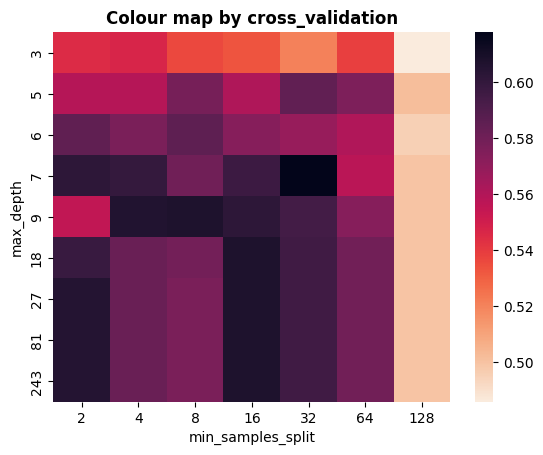

-------------------------
Best max depth: 7
Best min samlpes leaf: 32
Best f1-score: 0.618


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Выберем вот такие значения для перебора
max_depths = [3, 5, 6, 7, 9, 18, 27, 81, 243]
min_samples_splits = [2, 4, 8, 16, 32, 64, 128]

best_max_depth:int = None
best_min_samples_split:int = None
best_score:float = None

values = []

# Идем по глубинам
for max_depth in max_depths:
    cur_values = []
    # Идем по min_samples_split
    for min_samples_split in min_samples_splits:
        # Создаем модель
        rforest = RandomForestClassifier(n_estimators = 50,
                                         max_depth=max_depth,
                                         min_samples_split=min_samples_split,
                                         random_state=12)
        # В задании написано использовать в качестве критерия f1-меру
        # Будем ее использовать в кросс-валидации
        scorer = make_scorer(f1_score)
        scores = cross_val_score(rforest, X_train, y_train, scoring=scorer, cv=10)

        # Считаем и если что обновляем лучший score
        score = np.mean(scores)
        cur_values.append(score)
        if best_score is None or score > best_score:
            best_score = score
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
    values.append(cur_values)

# Построим heatmap, чтобы было лучше видно, где значения хорошие
data = pd.DataFrame(values, index=max_depths, columns=min_samples_splits)
sns.heatmap(data, cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.title('Colour map by cross_validation', fontweight='bold')
plt.show()

print('-------------------------')
print(f'Best max depth: {best_max_depth}')
print(f'Best min samlpes leaf: {best_min_samples_split}')
print(f'Best f1-score: {best_score:.3f}')

In [40]:
# Создаем RandomForestClassifier c нашими параметрами
rforest = RandomForestClassifier(n_estimators = 50,
                                 max_depth=best_max_depth,
                                 min_samples_split=best_min_samples_split,
                                 random_state=12)
# Обучаем и делаем предикты
rforest.fit(X_train, y_train)
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

# Добавим в нашу табличку новый столбец
table['RandomForest-Test'] = [accuracy_score(y_test, y_test_pred),
                              precision_score(y_test, y_test_pred),
                              recall_score(y_test, y_test_pred),
                              roc_auc_score(y_test, y_test_pred)]
table

,DTC-Train,DTC-Test,Bagging-Test,RandomForest-Test
Accuracy,0.849162,0.744589,0.783550,0.805195
Precision,0.757282,0.619565,0.718310,0.790323
Recall,0.834225,0.703704,0.629630,0.604938
Roc_auc,0.845684,0.703704,0.748148,0.759136


В Random forest у нас опять упал recall, но при этом другие метрики опять выросли. Можно сказать, что такая модель лучше чем предыщие.

Самая лучшая модель, глядя на метрики - RandomForest

#### Задание 3.5 (0.5 балла)
Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

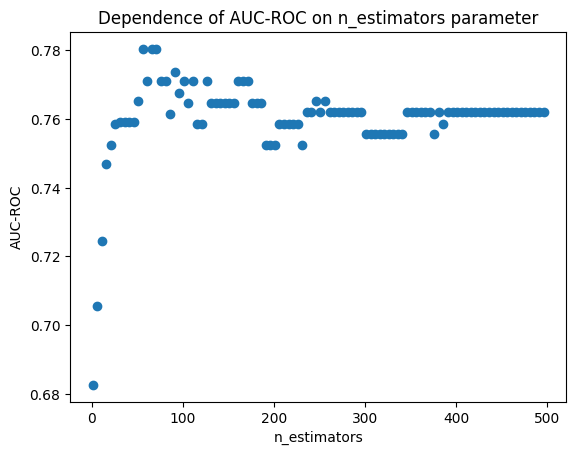

In [41]:
roc_auc = []

n_estimators = list(range(1, 500, 5))

for n_estimator in n_estimators:
    rforest = RandomForestClassifier(n_estimators = n_estimator,
                                     max_depth=best_max_depth,
                                     min_samples_split=best_min_samples_split,
                                     random_state=12)
    rforest.fit(X_train, y_train)
    y_test_pred = rforest.predict(X_test)
    roc_auc.append(roc_auc_score(y_test, y_test_pred))

plt.scatter(n_estimators, roc_auc)
plt.xlabel('n_estimators')
plt.ylabel('AUC-ROC')
plt.title('Dependence of AUC-ROC on n_estimators parameter')
plt.show()

Тут нельзя однозначно сказать, что происходит с AUC-ROC в зависимости от n_estimators.

Есть явный скачок при значениях n_estimators ~ 70, а дальше все немного стабилизируется на среднем уровне.

#### Задание 3.6 (0.5 балла)
Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

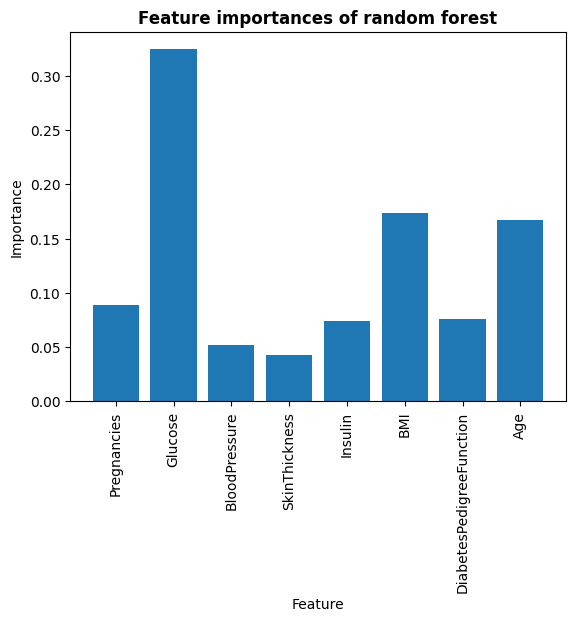

In [42]:
mean_importances = np.mean([tree.feature_importances_ for tree in rforest.estimators_], axis=0)

plt.bar(rforest.feature_names_in_, mean_importances)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature importances of random forest', fontweight='bold')
plt.show()

Самым полезным оказался показатель глюкозы (Glucose).

За ним идут BMI (индекс массы тела) и Age (возраст).

# Спасибо! Хорошего дня!